# Sklearn, XGBoost

## sklearn.ensemble.RandomForestClassifier

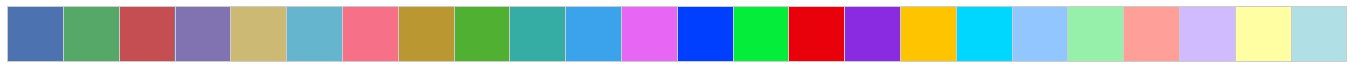

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

# will be in numpy >= 1.15
@contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)
        
def ndprint(a, precision=3):
    with printoptions(precision=precision, suppress=True):
        print(a)

In [2]:
from sklearn import datasets, metrics, model_selection as mdsel, tree, ensemble
import xgboost as xgb

### Данные

Задача на kaggle: https://www.kaggle.com/c/bioresponse

Данные: https://www.kaggle.com/c/bioresponse/data

По данным характеристикам молекулы требуется определить, будет ли дан биологический ответ (biological response).

Признаки нормализаваны.

Для демонстрации используется обучающая выборка из исходных данных train.csv, файл с данными прилагается.

In [4]:
bioresponce = pd.read_csv('data/17_19_bioresponse_train.csv', header=0, sep=',')

In [5]:
bioresponce.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [6]:
bioresponce_target = bioresponce.Activity.values

In [7]:
bioresponce_data = bioresponce.iloc[:, 1:]

### Модель RandomForestClassifier

#### Зависимость качества от количества деревьев

In [10]:
n_trees = [1] + np.arange(10, 55, 5) 

In [12]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
    score = mdsel.cross_val_score(estimator, bioresponce_data, bioresponce_target, 
                                             scoring = 'accuracy', cv = 3)    
    scoring.append(score)
scoring = np.asmatrix(scoring)

Wall time: 17.7 s


In [13]:
scoring

matrix([[0.76658673, 0.7496    , 0.7544    ],
        [0.77298161, 0.76      , 0.7624    ],
        [0.78497202, 0.7792    , 0.7696    ],
        [0.78577138, 0.7808    , 0.7728    ],
        [0.78177458, 0.7776    , 0.7696    ],
        [0.78497202, 0.7776    , 0.7824    ],
        [0.78896882, 0.7824    , 0.7816    ],
        [0.79536371, 0.7848    , 0.7888    ],
        [0.79216627, 0.7872    , 0.7896    ]])

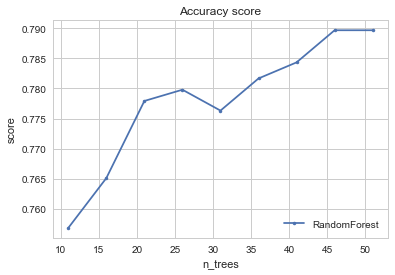

In [14]:
plt.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
plt.grid(True)
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc='lower right')

#### Кривые обучения для деревьев большей глубины

In [16]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = mdsel.cross_val_score(estimator, bioresponce_data, bioresponce_target, 
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

C:\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Wall time: 2min 29s


C:\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [17]:
xgb_scoring

matrix([[0.77777778, 0.772     , 0.772     ],
        [0.78177458, 0.7712    , 0.7768    ],
        [0.7833733 , 0.7776    , 0.7768    ],
        [0.79216627, 0.7752    , 0.7808    ],
        [0.79696243, 0.78      , 0.78      ],
        [0.79376499, 0.78      , 0.7784    ],
        [0.79456435, 0.7856    , 0.7792    ],
        [0.79936051, 0.7832    , 0.7848    ],
        [0.79776179, 0.784     , 0.784     ]])

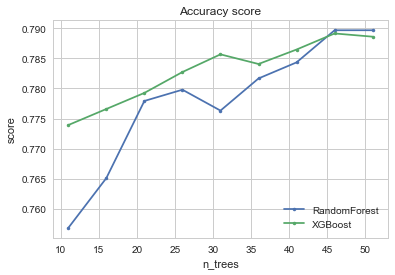

In [18]:
plt.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
plt.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
plt.grid(True)
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc='lower right')

#### **Если Вас заинтересовал xgboost:**
python api: http://xgboost.readthedocs.org/en/latest/python/python_api.html

установка: http://xgboost.readthedocs.io/en/latest/build.html